# Preparing Notebook

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#Pre-processing
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
#Clustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
#Evaluation
from sklearn.metrics import silhouette_score, make_scorer, homogeneity_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score

## Installing Dependencies

In [2]:
!pip install upsetplot --quiet
!pip install plotly --quiet
import plotly.graph_objects as go
import upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure required NLTK resources are downloaded
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Importing Data

In [4]:
df = pd.read_csv('/content/Department_-_Customer Review-4_2 - Sheet1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399 entries, 0 to 398
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       0 non-null      float64
 1   Unnamed: 1       0 non-null      float64
 2   Department       399 non-null    object 
 3   Unnamed: 3       0 non-null      float64
 4   Customer Review  399 non-null    object 
dtypes: float64(3), object(2)
memory usage: 15.7+ KB


In [5]:
df.drop(['Unnamed: 0','Unnamed: 1','Unnamed: 3'], axis= 'columns',inplace=True)

# Feature Processing & Engineering

In [6]:
# Removing Hashtags, Numbers & Special Characters
def clean_text(text):
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove symbols
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text.lower()  # Convert to lowercase

# Extracting Nouns
def extract_nouns(text):
    text = clean_text(text)
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    nouns = [word for word, tag in tagged_words if tag.startswith('NN')]
    return ' '.join(nouns)

# Removing Stopwords
def stopword_remover(text):
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [7]:
df['clean_text'] = df['Customer Review'].apply(clean_text)
df['processed_text'] = df['clean_text'].apply(lambda x: stopword_remover(extract_nouns(x)))

In [8]:
print(df[['Customer Review', 'clean_text', 'processed_text']].head())

                                     Customer Review  \
0  the best road king you can get in the market r...   
1  i must say tata harrier has absolutely best ro...   
2  tata harrier is the best car from tata, best r...   
3              real off-road car with premium looks.   
4  i bought this car last year still i love to dr...   

                                          clean_text  \
0  the best road king you can get in the market r...   
1  i must say tata harrier has absolutely best ro...   
2  tata harrier is the best car from tata best ro...   
3                real offroad car with premium looks   
4  i bought this car last year still i love to dr...   

                                      processed_text  
0                                        road market  
1                         tata harrier road presence  
2  tata harrier car tata road presence car compas...  
3                                  offroad car looks  
4  car year car spaciousit engine road cari car a..

In [9]:
opinion_list = df['processed_text'].tolist()

## Vectorizing Input

In [10]:
vectorizer = TfidfVectorizer(max_features = 500, min_df = 5, max_df= 0.9)
X = vectorizer.fit_transform(opinion_list)

## Scaling Input

In [11]:
scaler = StandardScaler(with_mean= False)
scaler.fit_transform(X)

<399x107 sparse matrix of type '<class 'numpy.float64'>'
	with 1665 stored elements in Compressed Sparse Row format>

In [12]:
np.unique(df['Department'].values).tolist()

['build quality', 'road presence', 'safety features']

## Encoding Labels

In [13]:
categories = [np.unique(df['Department'].values).tolist()]
enc = OrdinalEncoder(categories = categories)
df['encoded_labels'] = enc.fit_transform(df[['Department']])

In [14]:
y = df['encoded_labels']

## Dimensionality Reduction

In [15]:
pca = PCA(n_components=20, svd_solver = 'covariance_eigh')
pca.fit(X)

PCA(n_components=20, svd_solver='covariance_eigh')

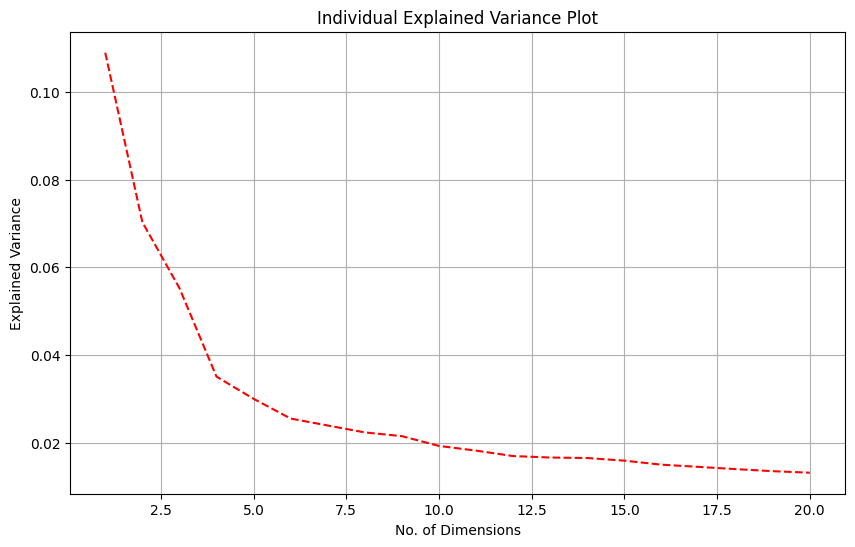

In [16]:
evr = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.plot(range(1,len(evr)+1), evr,  linestyle = '--', color = 'red', label = 'Individual Explained Variance')
plt.title('Individual Explained Variance Plot')
plt.xlabel('No. of Dimensions')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()


**Note:** The IEF plot shows that the dimensionality of the data can be reduced, therby helping in faster computation and better visualization potential. Here, we see a significant portion of the variance can be explained by the first 20 dimension components.

In [17]:
X_pca = pca.transform(X)

In [18]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca[:, :10])  # Using the first 10 components

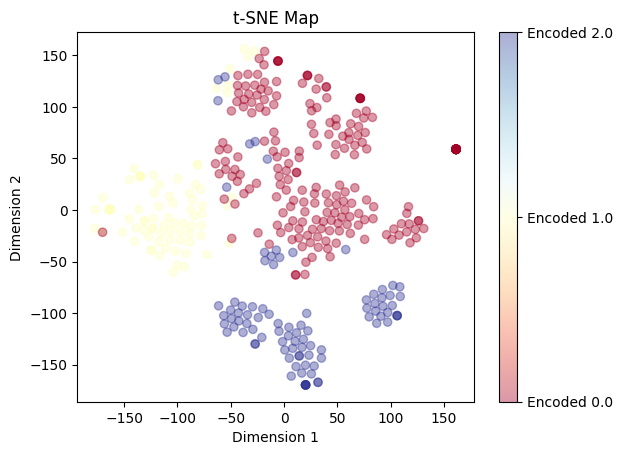

In [19]:
unique_labels = np.unique(df['encoded_labels'])
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha = 0.4, c=df['encoded_labels'], cmap='RdYlBu')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
cbar = plt.colorbar(scatter, ticks=unique_labels)
cbar.ax.set_yticklabels([f"Encoded {label}" for label in unique_labels])
plt.title('t-SNE Map')
plt.show()

**Note:** t-SNE is used as the data has a non-linearity component to it. This helps better visualize the cluster spread.

# Clustering Operations

## K-Means Clustering

### Optimizing for `k_values`

In [20]:
inertia = []
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k,max_iter = 100, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

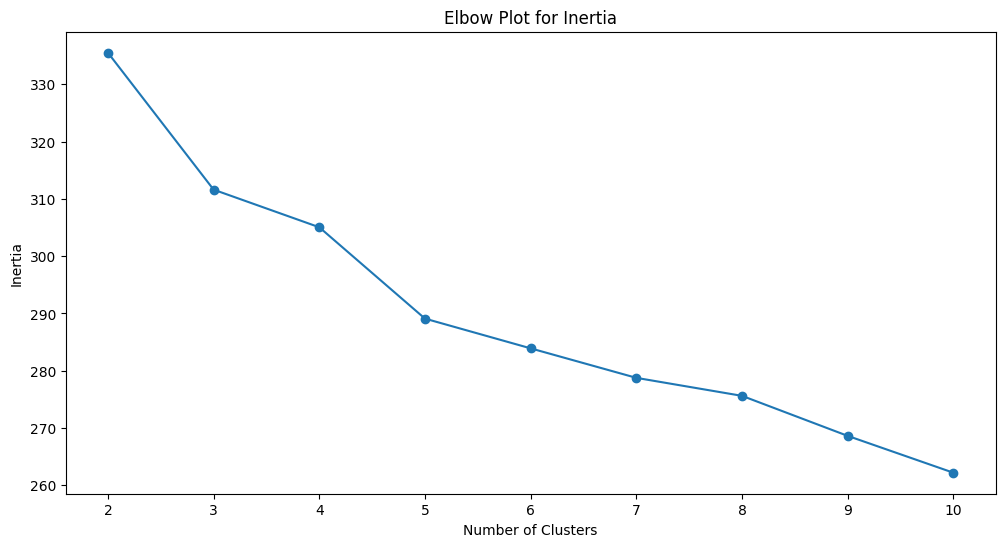

In [21]:
plt.figure(figsize=(12,6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Plot for Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

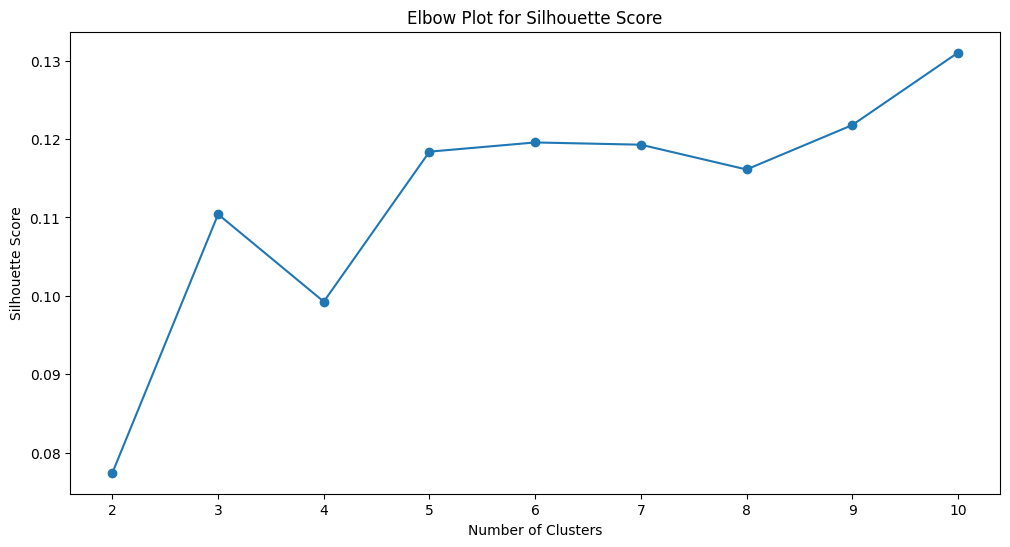

In [22]:
plt.figure(figsize=(12,6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Elbow Plot for Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Fitting Model to Data

In [23]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k,max_iter=1000, random_state=10)
kmeans.fit(X)
df['km_Cluster']=kmeans.fit_predict(X)

### Evaluating Model Performance

In [24]:
silhouette_avg = silhouette_score(X, df['km_Cluster'])
homogeneity = homogeneity_score(y, df['km_Cluster'])
ari = adjusted_rand_score(y, df['km_Cluster'])
nmi = normalized_mutual_info_score(y, df['km_Cluster'])
fmi = fowlkes_mallows_score(y, df['km_Cluster'])

new_row1 = ({
    'cluster_type': 'K-Means',
    'silhouette_score': silhouette_avg,
    'homogeneity_score': homogeneity,
    'adj_rand_score': ari,
    'norm_mutual_info': nmi,
    'fowlkes_mallows': fmi
})

### Cluster Visualizations

In [25]:
centroids = kmeans.cluster_centers_

In [26]:
cluster_centers_tsne = TSNE(n_components=3, random_state=42, perplexity=3).fit_transform(centroids)

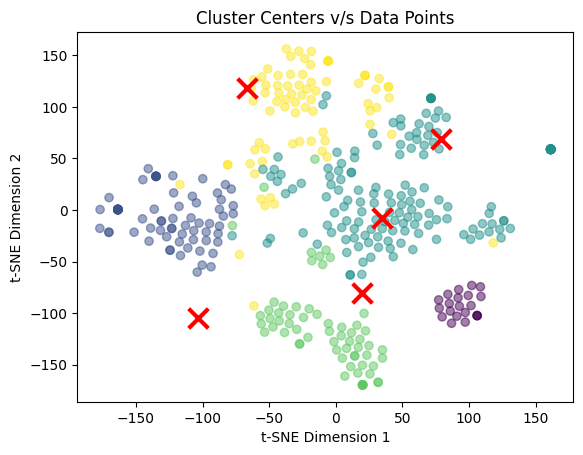

In [27]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)  # Data points
plt.scatter(cluster_centers_tsne[:, 0], cluster_centers_tsne[:, 1],
               marker='x', s=200, linewidths=3, color='r')  # Transformed cluster centers
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Cluster Centers v/s Data Points')
plt.show()

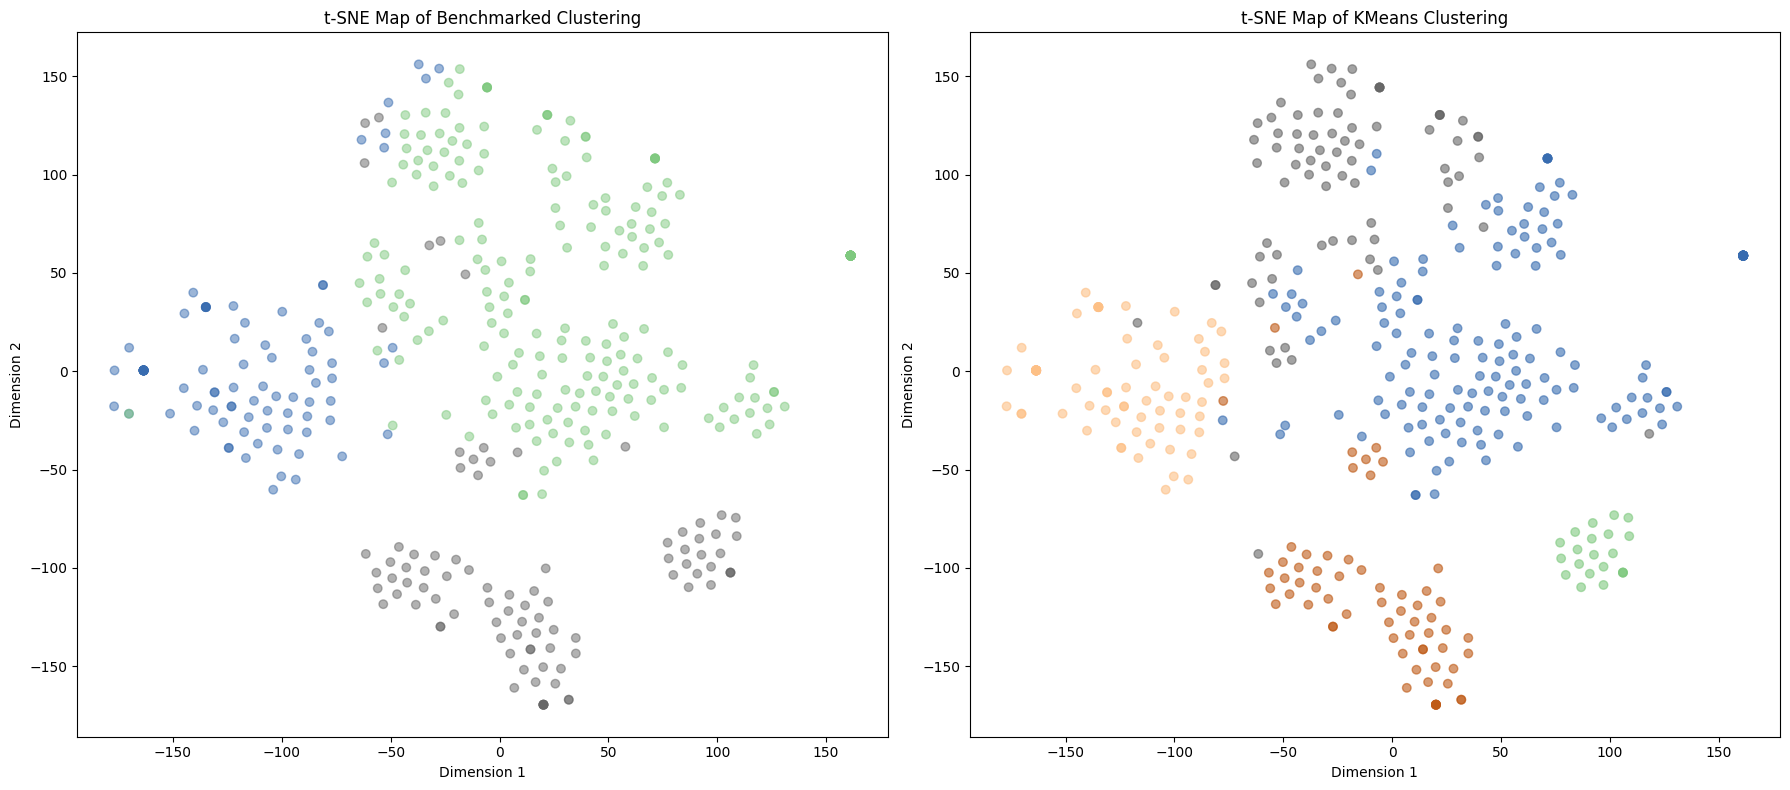

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['encoded_labels'],  cmap='Accent', marker='.', s=150, alpha = 0.5)
axes[0].set_title('t-SNE Map of Benchmarked Clustering')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['km_Cluster'], cmap='Accent', marker='.', s=150, alpha = 0.6)
axes[1].set_title('t-SNE Map of KMeans Clustering')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

In [29]:
# Create a contingency matrix
contingency_matrix = pd.crosstab(df['encoded_labels'], df['km_Cluster'])

# Normalize the matrix by row (encoded labels) to get proportions
cluster_proportions = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)

In [30]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Encoded 0", "Encoded 1", "Encoded 2"] + [f"KM {i}" for i in range(8)],
      color = "blue"
    ),
    link = dict(
      source = [i // 5 for i in range(contingency_matrix.size)],
      target = [i % 5 + 3 for i in range(contingency_matrix.size)],
      value = contingency_matrix.values.flatten()
  ))])

fig.update_layout(title_text="Alluvial Diagram: Original vs KMeans Clusters", font_size=10)
fig.show()

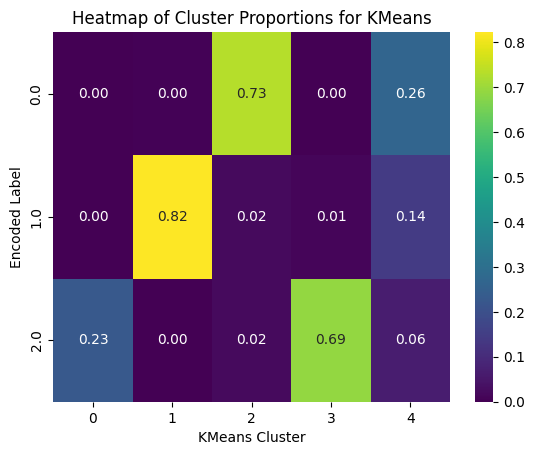

In [31]:
cluster_proportions = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)

# Plot the heatmap
sns.heatmap(cluster_proportions, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Cluster Proportions for KMeans')
plt.xlabel('KMeans Cluster')
plt.ylabel('Encoded Label')
plt.show()

## Hierarchical Clustering

### Optimizing for `n_clusters`

In [32]:
silhouette_scores = []
k_values = range(2, 11)
for k in k_values:
    hierarchical_clustering = AgglomerativeClustering(n_clusters=k)
    hierarchical_clustering.fit(X.toarray())
    silhouette_scores.append(silhouette_score(X, hierarchical_clustering.labels_))

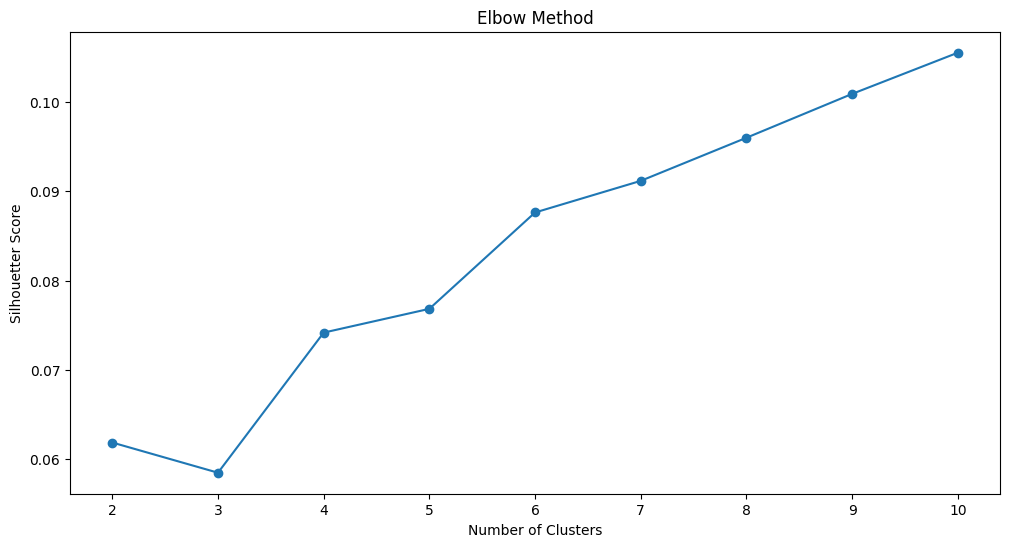

In [33]:
plt.figure(figsize=(12,6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouetter Score')
plt.show()

### Fitting Model to Data

In [34]:
optimal_n= 6
from sklearn.cluster import AgglomerativeClustering
hierarchical_clustering = AgglomerativeClustering(n_clusters= optimal_n, metric= 'l2',
                                                  linkage= 'average')
df['hc_Cluster'] = hierarchical_clustering.fit_predict(X.toarray())

## Evaluating Model Performance

In [35]:
silhouette_avg = silhouette_score(X, df['hc_Cluster'])
homogeneity = homogeneity_score(y, df['hc_Cluster'])
ari = adjusted_rand_score(y, df['hc_Cluster'])
nmi = normalized_mutual_info_score(y, df['hc_Cluster'])
fmi = fowlkes_mallows_score(y, df['hc_Cluster'])

new_row2 = ({
    'cluster_type': 'Hierarchical(Agglomerative)',
    'silhouette_score': silhouette_avg,
    'homogeneity_score': homogeneity,
    'adj_rand_score': ari,
    'norm_mutual_info': nmi,
    'fowlkes_mallows': fmi
})

### Cluster Visualizations

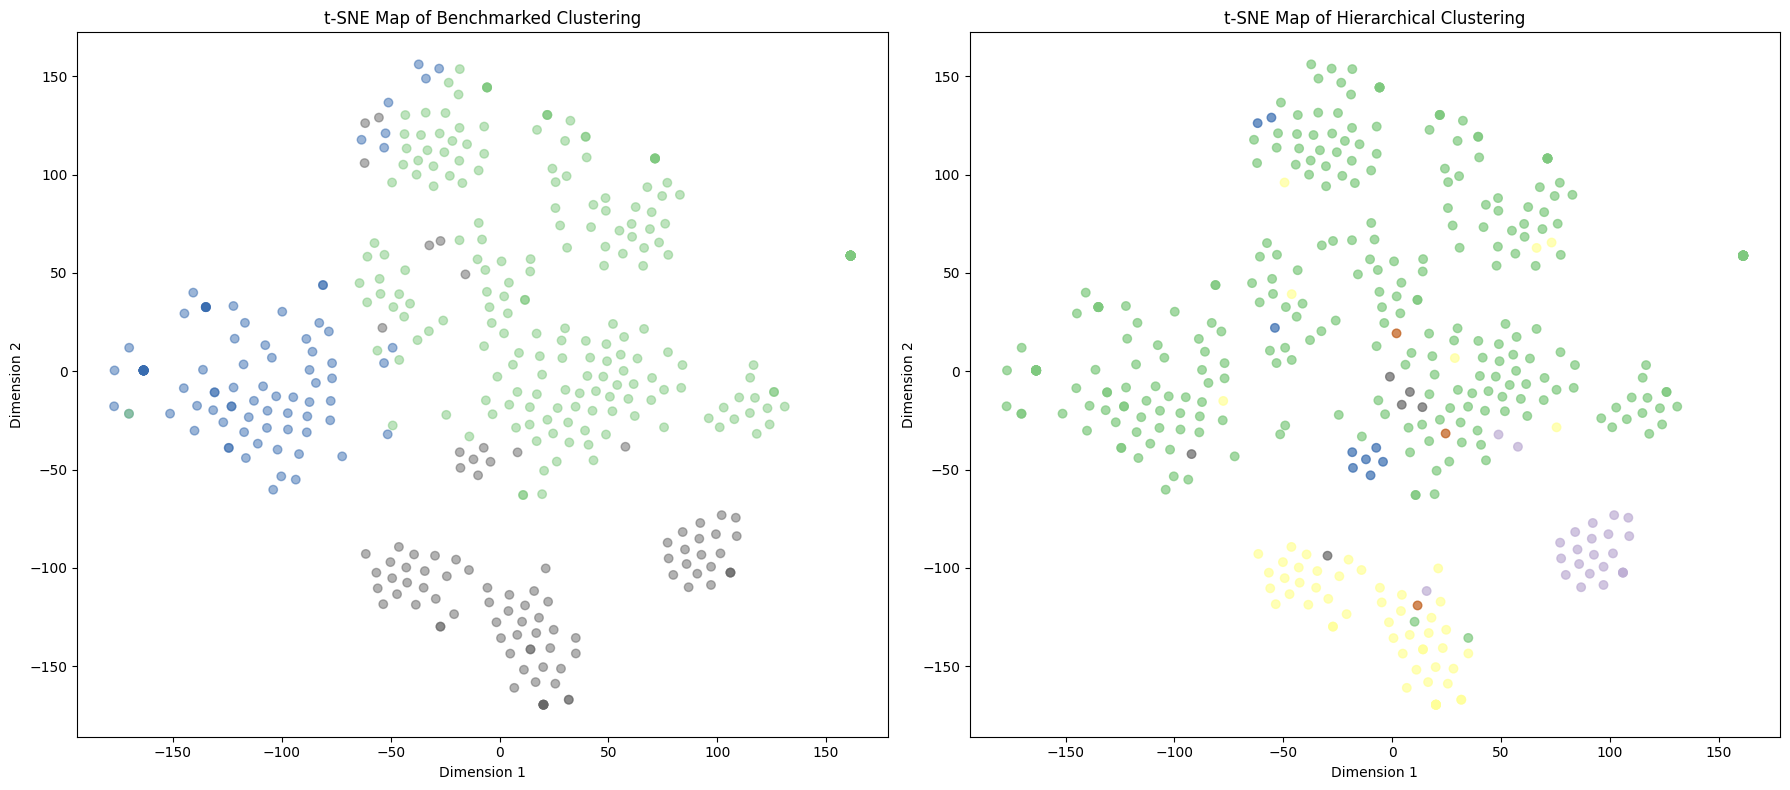

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['encoded_labels'],  cmap='Accent', marker='.', s=150, alpha = 0.5)
axes[0].set_title('t-SNE Map of Benchmarked Clustering')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['hc_Cluster'], cmap='Accent', marker='.', s=150, alpha = 0.7)
axes[1].set_title('t-SNE Map of Hierarchical Clustering')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

In [37]:
contingency_matrix = pd.crosstab(df['encoded_labels'], df['hc_Cluster'])
cluster_proportions = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)

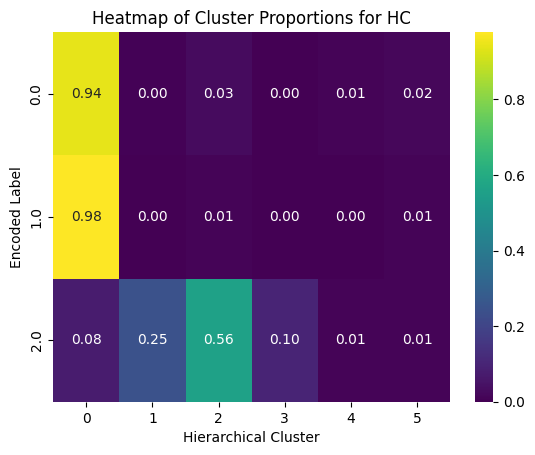

In [38]:
sns.heatmap(cluster_proportions, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Cluster Proportions for HC')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Encoded Label')
plt.show()

In [39]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = ["Encoded 0", "Encoded 1", "Encoded 2"] + [f"HC {i}" for i in range(6)],
      color = "blue"
    ),
    link = dict(
      source = [i // 7 for i in range(contingency_matrix.size)],
      target = [i % 7 + 3 for i in range(contingency_matrix.size)],
      value = contingency_matrix.values.flatten()
  ))])

fig.update_layout(title_text="Alluvial Diagram: Original vs. Hierarchical Clustering", font_size=10)
fig.show()

## DBSCAN

### Optimizing Parameters

In [40]:
pca = PCA(n_components=10, svd_solver='covariance_eigh')
X_dim_red = pca.fit_transform(X)
X_dim_red = scaler.fit_transform(X_dim_red)

In [41]:
X_pca.shape

(399, 20)

In [42]:
silhouette_scores = []
min_range = range(2, 11)
for min_values in min_range:
    dbscan = DBSCAN(eps=0.8, min_samples=min_values, metric = 'mahalanobis',
                    metric_params={'V': np.cov(X_dim_red.T)})
    dbscan.fit(X_dim_red)
    labels = dbscan.labels_
    if len(set(labels)) > 1:
        silhouette_scores.append(silhouette_score(X_dim_red, labels))
    else:
        silhouette_scores.append(-1)

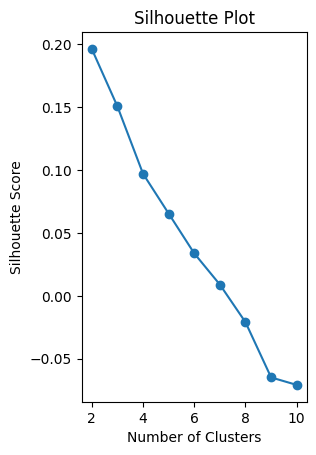

In [43]:
plt.subplot(1, 2, 2)
plt.plot(min_range, silhouette_scores, marker='o')
plt.title('Silhouette Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [44]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(X_dim_red)
distances, indices = neighbors_fit.kneighbors(X_dim_red)

In [45]:
X_tsne.shape

(399, 2)

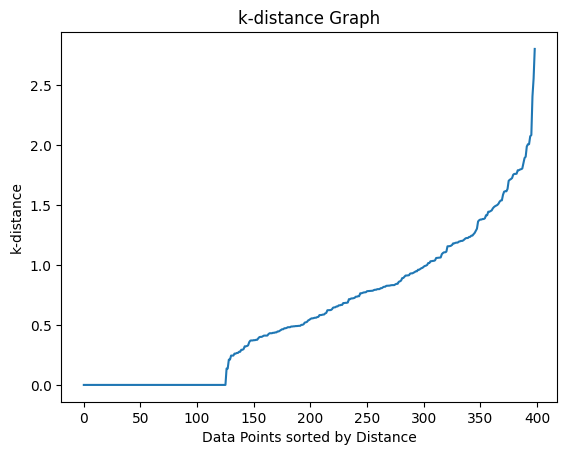

In [46]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('k-distance Graph')
plt.xlabel('Data Points sorted by Distance')
plt.ylabel('k-distance')
plt.show()

### Fitting Model to Data

In [47]:
optimal_min = 3
optimal_eps = 1.25
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min, metric= 'mahalanobis',
                metric_params={'V': np.cov(X_dim_red.T)})
df['dbs_Cluster'] = dbscan.fit_predict(X_dim_red)

### Evaluating Model Performance

In [48]:
ari = adjusted_rand_score(df['Department'], df['dbs_Cluster'])
nmi = normalized_mutual_info_score(df['Department'], df['dbs_Cluster'])
fmi = fowlkes_mallows_score(df['Department'], df['dbs_Cluster'])
homogeneity = homogeneity_score(df['Department'], df['dbs_Cluster'])

filtered_X = X[df['dbs_Cluster'] != -1]
filtered_labels = df['dbs_Cluster'][df['dbs_Cluster'] != -1]
silhouette_avg = silhouette_score(filtered_X, filtered_labels)

new_row3 = ({
    'cluster_type': 'DBSCAN',
    'silhouette_score': silhouette_avg,
    'homogeneity_score': homogeneity,
    'adj_rand_score': ari,
    'norm_mutual_info': nmi,
    'fowlkes_mallows': fmi
})

### Cluster Visualizations

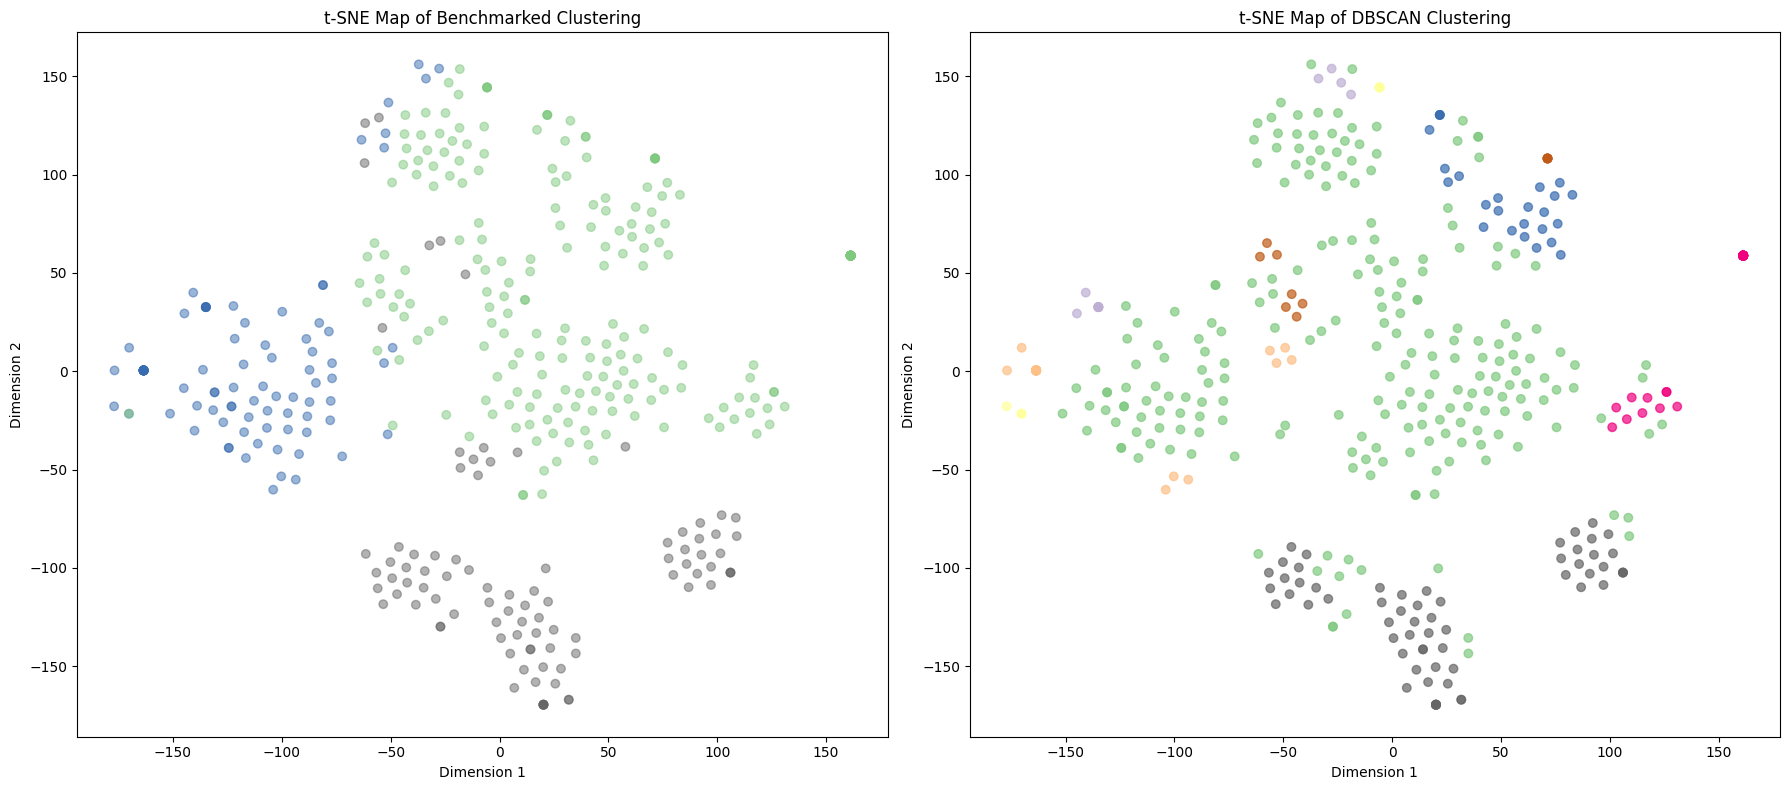

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['encoded_labels'],  cmap='Accent', marker='.', s=150, alpha = 0.5)
axes[0].set_title('t-SNE Map of Benchmarked Clustering')
axes[0].set_xlabel('Dimension 1')
axes[0].set_ylabel('Dimension 2')

axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c= df['dbs_Cluster'], cmap='Accent', marker='.', s=150, alpha = 0.7)
axes[1].set_title('t-SNE Map of DBSCAN Clustering')
axes[1].set_xlabel('Dimension 1')
axes[1].set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

In [50]:
contingency_matrix = pd.crosstab(df['encoded_labels'], df['dbs_Cluster'])
cluster_proportions = contingency_matrix.div(contingency_matrix.sum(axis=1), axis=0)


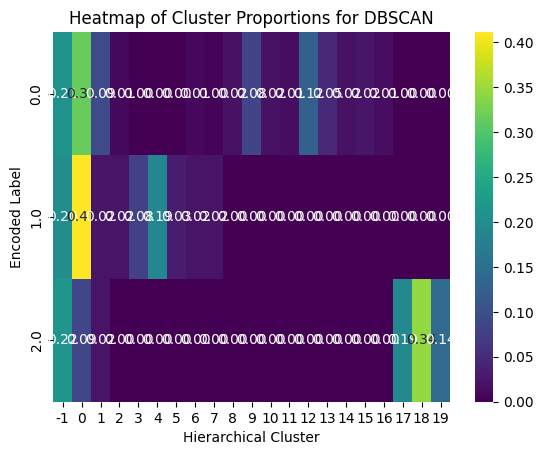

In [51]:
sns.heatmap(cluster_proportions, annot=True, cmap='viridis', fmt=".2f")
plt.title('Heatmap of Cluster Proportions for DBSCAN')
plt.xlabel('Hierarchical Cluster')
plt.ylabel('Encoded Label')
plt.show()

In [52]:
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=["Original " + str(i) for i in range(len(contingency_matrix))] + ["DBSCAN " + str(i) for i in range(len(contingency_matrix.columns))],
        color="blue"
    ),
    link=dict(
        source=[i for i in range(len(contingency_matrix)) for j in range(len(contingency_matrix.columns))],
        target=[len(contingency_matrix) + j for i in range(len(contingency_matrix)) for j in range(len(contingency_matrix.columns))],
        value=contingency_matrix.values.flatten()
    ))])

fig.update_layout(title_text="Alluvial Diagram: Original vs. DBSCAN", font_size=10)
fig.show()

# Model Comparison

In [53]:
new_row1 = pd.DataFrame([new_row1])
new_row2 = pd.DataFrame([new_row2])
new_row3 = pd.DataFrame([new_row3])
results_df = pd.concat([new_row1, new_row2, new_row3], ignore_index=True)

In [54]:
results_df

,cluster_type,silhouette_score,homogeneity_score,adj_rand_score,norm_mutual_info,fowlkes_mallows
0,K-Means,0.119150,0.784607,0.597628,0.644252,0.740292
1,Hierarchical(Agglomerative),0.062621,0.385213,0.371218,0.416740,0.680536
2,DBSCAN,0.188373,0.498553,0.083390,0.298406,0.313867


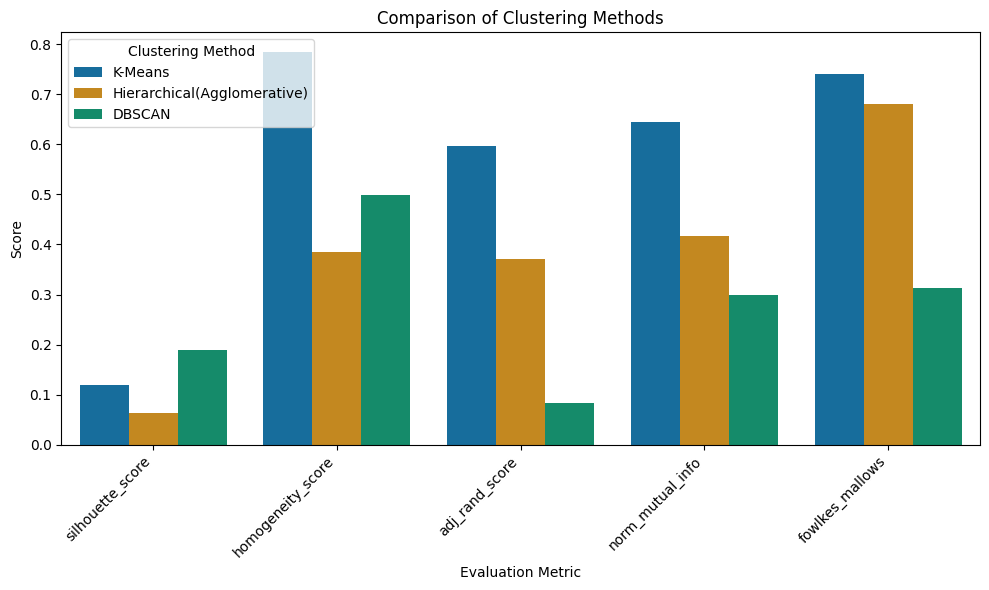

In [55]:
results_melted = pd.melt(results_df, id_vars=['cluster_type'], var_name='metric', value_name='score')

plt.figure(figsize=(10, 6))
sns.barplot(x='metric', y='score', hue='cluster_type', data=results_melted, palette = 'colorblind')
plt.title('Comparison of Clustering Methods')
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Clustering Method')
plt.tight_layout()
plt.show()

# Conclusions

* **K-Means** has outperformed the other models across the board. Its high *homogeneity* and *Fowlkes-Mallows* score indicate clusters are **homogeneous** and have **high** agreement with ground truth labels. Its low **silhouette score** can be attributed to a small dataset with non-linear elements oweing to a weaker fitting.

* **Agglomerative Clustering** has achieved moderate score compared to other models. Its inability to clearly cluster **0** and **2** labels has led to a low **homogeneity** and an even lower **silhouette score** as a result of its inability to create well-defined clusters. However, with higher cluster numbers it has managed to overcome its shortcoming to an extent showing a good **adjusted rand score** and a **Normalised Mutual Info** signifying a somewhat **decent** agreement with ground truths.

* Although **DBSCAN** has achieved the highest **silhouette score** it has consistently struggled to create well defined clusters from the noise. Its weakness to the *curse of dimensionality* has led to **poor** alignment with true class labels as signified by poor **adjusted rand** and **Fowlkes-Mallows** score .